# Capsone Project-- DNN based speaker verification system 

Zhihong Zhang

Original idea of this Capstone project is to implement the CNN structure to a given method and implement the transfer learning based on cnn layer to other resource-lacked environmenrt. 

The work can be simply seperated into three part, preprocessing, modeling and the improvement. 

For the preprocessing part. This part is to preprocess audio data, and change it into numpy form based on the fast Fourier Transform.
Underpreprocessing folder, I also implement some preprocressing code for computing

# Set up

For this project, I would like to mainly use pytorch to deal with the model for its simplicity and debugging part. Most writing work will be showed in this colab file, only some mentioned model and revised code will be in the github repository. 

For the set-up of the project, the setting up is based on the paper of 
project of 

In [ ]:
from __future__ import print_function
import requests
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seem for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


During the import library part, I use manual seed to make sure result can be replicate by other peoplle. 

tf example: https://www.kaggle.com/beastlyprime/tensorflow-speaker-verification 

In [ ]:
#for model work properly
import os

import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split



In [ ]:
#set up tensorboard
# Call flush() method to make sure that all pending events have been written to disk.
#import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
!pip install tensorboard

Also, we set up tensorboard for late tuning the hyperparameter

Here we can check our computing device

In [ ]:
# Check GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


If choose to work with the colab, except the work of make sure have done some set up

In [ ]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.ion()   # interactive mode

plp code:
https://github.com/mystlee/rasta_py/blob/master/rasta.py

In [ ]:
#install torch audio
!pip install torchaudio

     |████████████████████████████████| 7.6MB 11.4MB/s 
     |████████████████████████████████| 776.8MB 23kB/s 
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


# Data Preprocess

In this version, I will show some basic form of the use Librispeech dataset only for its ease accessibility. Since dataset is large, it is better to saved it to the google drive. And the modeling trainning will be very long considering.

In [ ]:
#import torchaudio
#use train clean 100 for train, technically can use other form
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True)
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)


The generated file will be on the colab virtual machine instance. To save for late use, we can extract file into gdrive or copy to file directly with !cp command. 

In [ ]:
# The way to export data to local instance
#extract data to colab
#import shutil
#shutil.unpack_archive("/content/drive/MyDrive/libri/test-clean.tar.gz", "/content/")
#shutil.unpack_archive("/content/drive/MyDrive/libri/train-clean-100.tar.gz", "/content/")
#shutil.unpack_archive("/content/drive/MyDrive/libri/dev-clean.tar.gz", "/content/")

Or, I can copy data from google drive

If it is the second time run, and the file is already stored at Google drive. For convenience we directly get file from the gdrive to virtual instance, generally it loaded file faster if the file is loaded from instance instead of the google dive path. 

In [ ]:
## also slow on copy from google drive to instance 
!cd "drive/MyDrive/libri/"
%cp -av "/content/drive/MyDrive/libri/test-clean.tar.gz" "/content/"
%cp -av "/content/drive/MyDrive/libri/train-clean-100.tar.gz" "/content/"

'/content/drive/MyDrive/libri/test-clean.tar.gz' -> '/content/test-clean.tar.gz'
'/content/drive/MyDrive/libri/train-clean-100.tar.gz' -> '/content/train-clean-100.tar.gz'


In [ ]:
#set up file path
train_path = "/content/drive/MyDrive/LibriSpeech/train-clean-100/"
test_path  = "/content/drive/MyDrive/LibriSpeech/test-clean/"
dev_path   = "/content/drive/MyDrive/LibriSpeech/dev-clean/"

## Format convert for a data source
Since vctk, librispeech are all in flac format and this is not be well-supported by the librosa, I need to do the batch cnversion first. pydub is one way to convert the file. The tested conversion method,file_to_wav.py, was created under the from github folder

In [ ]:
!pip install pydub

In [ ]:
#Here I tried to convert form and used old method to finish the part. 

import pydub
import os
import tqdm
import glob
class Flac2Wav:
  def flac2wav(filepath):
    base_file_path = os.path.dirname(filepath)
    filename = os.path.basename(filepath)
    filename_no_ext = os.path.splitext(filename)[0]
    audio = AudioSegment.from_file(filepath, "flac")
    wav_file_path = base_file_path + '/' + filename_no_ext +'.wav'
    audio.export(wav_file_path, format="wav")
 
  def convert_flac_to_wav(train_path, dev_path, test_path):
    train_flac = [file for file in glob.glob(train_path + "/*/*/*.flac")]
    dev_flac = [file for file in glob.glob(dev_path + "/*/*/*.flac")]
    test_flac = [file for file in glob.glob(test_path + "/*/*/*.flac")]
   
    print("Converting %d train %d dev and %d test flac files into wav files"
          % (len(train_flac), len(dev_flac), len(test_flac)))   
   
    print("Processing train")
    for f in tqdm(train_flac):
        flac2wav(f)
   
    print("Processing dev")
    for f in tqdm(dev_flac):
        flac2wav(f)
       
    print("Processing test")
    for f in tqdm(test_flac):
        flac2wav(f)
  



if __name__ == "__main__":
    Flac2Wav()



  

In [ ]:
#check the audio file
from IPython.display import Audio
sample1= Audio("/content/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac")
sample1

In [ ]:
# show the graph of the sample file
waveform, sample_rate = torchaudio.load("/content/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac", normalization=True)

plt.plot(waveform.t())
audio_1=waveform.t().numpy()

OSError: ignored

In [ ]:
!pip install soundfile

In [ ]:
import numpy as np
import librosa
import librosa.display
import soundfile
import matplotlib.pyplot as plt

# A function to draw a spectrogram:
def draw_spectrogram(filename, window_size=0.025, window_shift=0.010):
  audio_signal, sampling_rate = soundfile.read(filename)
  window_length = int(window_size * sampling_rate)
  hop_length = int(window_shift * sampling_rate)

  spectrogram = np.abs(librosa.stft(audio_signal, hop_length=hop_length, win_length=window_length))

  # Plotting the spectrogram:
  librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), sr=sampling_rate, hop_length=hop_length, y_axis='linear', x_axis='time')
  plt.title('Spectrogram')
  plt.colorbar(format='%+2.0f dB')
  plt.tight_layout()

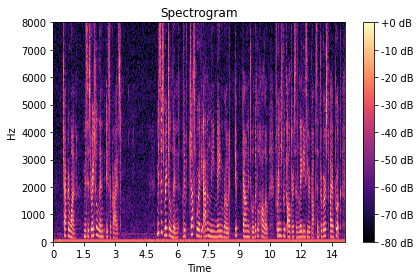

In [ ]:
#use example to make plot
draw_spectrogram("/content/drive/MyDrive/LibriSpeech/train-clean-100/103/1240/103-1240-0000.flac")

As the spectrum showed, the feature of the audio can be represented in the form of the image. And the spectrum can still keep this important information of the audio. In the diagram it showed the audio graph has depth of the decibel. This is the important feature of describing power on a log scale. 

Another alternate method is to generate plp features instead of the mfcc, plp method seems provide a better detail compared to mfcc. 

Here for the baseline work, we switched back to TIMIT for its relatively small size. 

In [ ]:
## check example 
import numpy as np
TIMIT_sample= np.load("/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker0.npy")
TIMIT_sample

array([[[-5.783076 , -5.4550424, -4.4849415, ..., -3.8178372,
         -4.186981 , -4.0036488],
        [-5.993415 , -5.3618574, -4.4346747, ..., -3.4750547,
         -3.6915107, -3.7748134],
        [-5.989384 , -5.605701 , -4.6029243, ..., -3.1912458,
         -3.51342  , -3.5629208],
        ...,
        [-5.986337 , -5.2103047, -4.783456 , ..., -5.1597996,
         -5.7536016, -5.8234572],
        [-5.9906387, -5.1042953, -4.593709 , ..., -5.579624 ,
         -5.905373 , -5.897026 ],
        [-5.9922304, -5.0980163, -4.6106286, ..., -5.9161696,
         -5.968594 , -5.946773 ]],

       [[-5.6854367, -5.917743 , -5.5145793, ..., -5.8444624,
         -5.9379754, -5.722743 ],
        [-5.9418545, -5.96453  , -5.2898207, ..., -5.7666254,
         -5.856822 , -5.747618 ],
        [-5.9798365, -5.964807 , -5.1291866, ..., -5.510087 ,
         -5.544435 , -5.4631457],
        ...,
        [-5.994161 , -5.994068 , -5.9688444, ..., -5.837489 ,
         -5.9268045, -5.9378333],
        [-5.

We can see how it looks like in the form of numpy. In order to have a better view and since pytorch will be the main framework used in the project, now we switch it to tensor form.

In [ ]:
## change to tensor
t1=torch.from_numpy(TIMIT_sample)
t1

tensor([[[-5.7831, -5.4550, -4.4849,  ..., -3.8178, -4.1870, -4.0036],
         [-5.9934, -5.3619, -4.4347,  ..., -3.4751, -3.6915, -3.7748],
         [-5.9894, -5.6057, -4.6029,  ..., -3.1912, -3.5134, -3.5629],
         ...,
         [-5.9863, -5.2103, -4.7835,  ..., -5.1598, -5.7536, -5.8235],
         [-5.9906, -5.1043, -4.5937,  ..., -5.5796, -5.9054, -5.8970],
         [-5.9922, -5.0980, -4.6106,  ..., -5.9162, -5.9686, -5.9468]],

        [[-5.6854, -5.9177, -5.5146,  ..., -5.8445, -5.9380, -5.7227],
         [-5.9419, -5.9645, -5.2898,  ..., -5.7666, -5.8568, -5.7476],
         [-5.9798, -5.9648, -5.1292,  ..., -5.5101, -5.5444, -5.4631],
         ...,
         [-5.9942, -5.9941, -5.9688,  ..., -5.8375, -5.9268, -5.9378],
         [-5.9942, -5.9904, -5.9800,  ..., -5.8333, -5.8794, -5.9449],
         [-5.9925, -5.9847, -5.9888,  ..., -5.5298, -5.8002, -5.8842]],

        [[-5.3659, -5.2138, -5.1779,  ..., -3.2970, -3.3166, -3.2851],
         [-5.8404, -5.5970, -5.3171,  ..., -2

In [ ]:
t1.shape

torch.Size([8, 40, 180])

We get to know example tesor demension, it is 40*180 matrix with 8 batch size of this specific audio.


40 comes from prepocessed process of 40 nmels, which is the mels energy and the 180 comes from the frames we selected from the 

and we can better used for later

### Computing the mfcc features

Now we come back to this librispeech dataset.

Here showed how to do this process, then mfcc will be computed through this process to convert the audio into numpy form

In [ ]:
#torchaudio.transforms.FrequencyMasking()
#torchaudio.transforms.TimeMasking()

then

In [ ]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)


class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):
    """Speech Recognition Model Inspired by DeepSpeech 2"""

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

optimizer

In [ ]:
from torch import optim 

last step

Then built based on the 


speaker features:
https://github.com/jameslyons/python_speech_features

https://appliedmachinelearning.blog/2017/11/14/spoken-speaker-identification-based-on-gaussian-mixture-models-python-implementation/

In [ ]:
#How to run 
import numpy as np
from sklearn import preprocessing
import python_speech_features as mfcc

def calculate_delta(array):
    """Calculate and returns the delta of given feature vector matrix"""

    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
              first =0
            else:
              first = i-j
            if i+j > rows-1:
                second = rows-1
            else:
                second = i+j 
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

def extract_features(audio,rate):
    """extract 20 dim mfcc features from an audio, performs CMS and combines 
    delta to make it 40 dim feature vector"""    
    
    mfcc_feature = mfcc.mfcc(audio,rate, 0.025, 0.01,20,nfft = 1200, appendEnergy = True)    
    mfcc_feature = preprocessing.scale(mfcc_feature)
    delta = calculate_delta(mfcc_feature)
    combined = np.hstack((mfcc_feature,delta)) 
    return combined

Authencation process for load file from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

https://discuss.pytorch.org/t/how-to-save-model-weights-to-local-machine-from-colab/33318/2

save models

In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode


## Install TorchAudio
!pip install torchaudio>=0.6.0 -f https://download.pytorch.org/whl/torch_stable.html


## Way of processing the audio

Here we still showed how the file may look like if librispeech data set is not go through format conversion

In [ ]:
#prepared paprameter and function for later usage
#librispeech
import glob
import os
import librosa
import numpy as np
# downloaded dataset path
audio_path = glob.glob(os.path.dirname('/content/drive/MyDrive/LibriSpeech/*/*/*/*.flac')) 
train_path = '/content/drive/MyDrive/LibriSpeech/train_tisv'
test_path  = '/content/drive/MyDrive/LibriSpeech/test_tisv'

In [ ]:
# for convenience ,define parameter for hp term
tisv_frame= 180
hop = 0.01
window =0.025 #s
#train_path_unprocessed= './TIMIT/TRAIN/*/*/*.wav'
train_path_unprocessed= '/content/drive/MyDrive/LibriSpeech/train-clean-100/*/*/*.wav'
#test_path_unprocessed: './TIMIT/TEST/*/*/*.wav'
test_path_unprocessed: '/content/drive/MyDrive/LibriSpeech/test-clean/*/*/*.wav'
nfft =512
nmels =40

In [ ]:
#copy timit to local colab

In [ ]:
# this is for convert data into numpy 

#----------------------------------------------


def save_spectrogram_tisv():
    """ Full preprocess of text independent utterance. The log-mel-spectrogram is saved as numpy file.
        Each partial utterance is splitted by voice detection using DB
        and the first and the last 180 frames from each partial utterance are saved. 
        Need : utterance data set (VTCK)
    """
    print("start text independent utterance feature extraction")
    sr= 16000
    os.makedirs(train_path, exist_ok=True)   # make folder to save train file
    os.makedirs(test_path, exist_ok=True)    # make folder to save test file

    utter_min_len = (tisv_frame * hop + window) * sr    # lower bound of utterance length
    total_speaker_num = len(audio_path)
    train_speaker_num= (total_speaker_num//10)*9            # split total data 90% train and 10% test
    print("total speaker number : %d"%total_speaker_num)
    print("train : %d, test : %d"%(train_speaker_num, total_speaker_num-train_speaker_num))
    for i, folder in enumerate(audio_path):
        print("%dth speaker processing..."%i)
        utterances_spec = []
        for utter_name in os.listdir(folder):
            if utter_name[-4:] == '.flac':
                utter_path = os.path.join(folder, utter_name)         # path of each utterance
                utter, sr = torchaudio.load(utter_path, sr)        # load utterance audio
                intervals = torchaudio.effects.split(utter, top_db=10)         # voice activity detection 
                # this works fine for timit but if you get array of shape 0 for any other audio change value of top_db
                # for vctk dataset use top_db=100
                for interval in intervals:
                    if (interval[1]-interval[0]) > utter_min_len:           # If partial utterance is sufficient long,
                        utter_part = utter[interval[0]:interval[1]]         # save first and last 180 frames of spectrogram.
                        S = librosa.core.stft(y=utter_part, n_fft=nfft,
                                              win_length=int(window * sr), hop_length=int(hop * sr))
                        S = np.abs(S) ** 2
                        mel_basis = librosa.filters.mel(sr=sr, n_fft=nfft, n_mels=nmels)
                        S = np.log10(np.dot(mel_basis, S) + 1e-6)           # log mel spectrogram of utterances
                        utterances_spec.append(S[:, :tisv_frame])    # first 180 frames of partial utterance
                        utterances_spec.append(S[:, -tisv_frame:])   # last 180 frames of partial utterance

        utterances_spec = np.array(utterances_spec)
        print(utterances_spec.shape)
        if i<train_speaker_num:      # save spectrogram as numpy file
            np.save(os.path.join(train_path, "speaker%d.npy"%i), utterances_spec)
        else:
            np.save(os.path.join(test_path, "speaker%d.npy"%(i-train_speaker_num)), utterances_spec)


if __name__ == "__main__":
    save_spectrogram_tisv()

start text independent utterance feature extraction
total speaker number : 769
train : 684, test : 85
0th speaker processing...
(0,)
1th speaker processing...
(0,)
2th speaker processing...
(0,)
3th speaker processing...
(0,)
4th speaker processing...
(0,)
5th speaker processing...
(0,)
6th speaker processing...
(0,)
7th speaker processing...
(0,)
8th speaker processing...
(0,)
9th speaker processing...
(0,)
10th speaker processing...
(0,)
11th speaker processing...
(0,)
12th speaker processing...
(0,)
13th speaker processing...
(0,)
14th speaker processing...
(0,)
15th speaker processing...
(0,)
16th speaker processing...
(0,)
17th speaker processing...
(0,)
18th speaker processing...
(0,)
19th speaker processing...
(0,)
20th speaker processing...
(0,)
21th speaker processing...
(0,)
22th speaker processing...
(0,)
23th speaker processing...
(0,)
24th speaker processing...
(0,)
25th speaker processing...
(0,)
26th speaker processing...
(0,)
27th speaker processing...
(0,)
28th speaker

It will not work for the original data set,since the librosa cannot handle the file other than wav form, I create a to_wav script under the prepocessing folder can be used to convcert flac to wav, since the method is tested on the local machine, It will need to be revised a bit to be merged in this colab environment.  

In [ ]:
## check example 
import numpy as np
Libri_sample= np.load("/content/drive/MyDrive/LibriSpeech/train_tisv/speaker0.npy")
Libri_sample

array([], dtype=float64)

We continue with the baseline code of TIMIT data

In [ ]:
#prepared paprameter and function for later usage
import glob
import os
import librosa
import numpy as np
# downloaded dataset path
audio_path = glob.glob(os.path.dirname('/content/drive/MyDrive/TIMIT/*/*/*/*.wav')) 
train_path = './train_tisv'
test_path  = './test_tisv'

In [ ]:
# for convenience ,define parameter for hp term
tisv_frame= 180
hop = 0.01
window =0.025 #s
#train_path_unprocessed= './TIMIT/TRAIN/*/*/*.wav'
train_path_unprocessed= '/content/drive/MyDrive/TIMIT/TRAIN/*/*/*.wav'
#test_path_unprocessed: './TIMIT/TEST/*/*/*.wav'
test_path_unprocessed: '/content/drive/MyDrive/TIMIT/TEST/*/*/*.wav'
nfft =512
nmels =40

In [ ]:
#preprocess copy TIMIT
#%cp -av "/content/drive/MyDrive/TIMIT" "/content/"


In [ ]:
# this is for convert data into numpy 

#----------------------------------------------


#def save_spectrogram_tisv():
    """ Full preprocess of text independent utterance. The log-mel-spectrogram is saved as numpy file.
        Each partial utterance is splitted by voice detection using DB
        and the first and the last 180 frames from each partial utterance are saved. 
        Need : utterance data set (VTCK)
    """
    print("start text independent utterance feature extraction")
    sr= 16000
    os.makedirs(train_path, exist_ok=True)   # make folder to save train file
    os.makedirs(test_path, exist_ok=True)    # make folder to save test file

    utter_min_len = (tisv_frame * hop + window) * sr    # lower bound of utterance length
    total_speaker_num = len(audio_path)
    train_speaker_num= (total_speaker_num//10)*9            # split total data 90% train and 10% test
    print("total speaker number : %d"%total_speaker_num)
    print("train : %d, test : %d"%(train_speaker_num, total_speaker_num-train_speaker_num))
    for i, folder in enumerate(audio_path):
        print("%dth speaker processing..."%i)
        utterances_spec = []
        for utter_name in os.listdir(folder):
            if utter_name[-4:] == '.WAV':
                utter_path = os.path.join(folder, utter_name)         # path of each utterance
                utter, sr = librosa.core.load(utter_path, sr)        # load utterance audio
                intervals = librosa.effects.split(utter, top_db=30)         # voice activity detection 
                # this works fine for timit but if you get array of shape 0 for any other audio change value of top_db
                # for vctk dataset use top_db=100
                for interval in intervals:
                    if (interval[1]-interval[0]) > utter_min_len:           # If partial utterance is sufficient long,
                        utter_part = utter[interval[0]:interval[1]]         # save first and last 180 frames of spectrogram.
                        S = librosa.core.stft(y=utter_part, n_fft=nfft,
                                              win_length=int(window * sr), hop_length=int(hop * sr))
                        S = np.abs(S) ** 2
                        mel_basis = librosa.filters.mel(sr=sr, n_fft=nfft, n_mels=nmels)
                        S = np.log10(np.dot(mel_basis, S) + 1e-6)           # log mel spectrogram of utterances
                        utterances_spec.append(S[:, :tisv_frame])    # first 180 frames of partial utterance
                        utterances_spec.append(S[:, -tisv_frame:])   # last 180 frames of partial utterance

        utterances_spec = np.array(utterances_spec)
        print(utterances_spec.shape)
        if i<train_speaker_num:      # save spectrogram as numpy file
            np.save(os.path.join(train_path, "speaker%d.npy"%i), utterances_spec)
        else:
            np.save(os.path.join(test_path, "speaker%d.npy"%(i-train_speaker_num)), utterances_spec)


if __name__ == "__main__":
    save_spectrogram_tisv()

start text independent utterance feature extraction
total speaker number : 630
train : 567, test : 63
0th speaker processing...
(12, 40, 180)
1th speaker processing...
(12, 40, 180)
2th speaker processing...
(18, 40, 180)
3th speaker processing...
(16, 40, 180)
4th speaker processing...
(20, 40, 180)
5th speaker processing...
(10, 40, 180)
6th speaker processing...
(8, 40, 180)
7th speaker processing...
(18, 40, 180)
8th speaker processing...
(14, 40, 180)
9th speaker processing...
(14, 40, 180)
10th speaker processing...
(16, 40, 180)
11th speaker processing...
(12, 40, 180)
12th speaker processing...
(16, 40, 180)
13th speaker processing...
(14, 40, 180)
14th speaker processing...
(18, 40, 180)
15th speaker processing...
(14, 40, 180)
16th speaker processing...
(8, 40, 180)
17th speaker processing...
(18, 40, 180)
18th speaker processing...
(12, 40, 180)
19th speaker processing...
(18, 40, 180)
20th speaker processing...
(8, 40, 180)
21th speaker processing...
(18, 40, 180)
22th spea

To quickly move file from google drive to virtual instance, we can use copy command as well. 

In [ ]:
#For convenience we copy term from gdrive

%cp -av "/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv" "/content/"
%cp -av "/content/drive/MyDrive/PyTorch_Speaker_Verification-master/test_tisv" "/content/"

'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv' -> '/content/train_tisv'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker0.npy' -> '/content/train_tisv/speaker0.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker112.npy' -> '/content/train_tisv/speaker112.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker127.npy' -> '/content/train_tisv/speaker127.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker130.npy' -> '/content/train_tisv/speaker130.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker117.npy' -> '/content/train_tisv/speaker117.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker131.npy' -> '/content/train_tisv/speaker131.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker129.npy' -> '/content/train_tisv/speaker129.npy'
'/content/drive/My

In [ ]:
#For convenience we copy term from gdrive, if we donot want to train prepocessed audio everytime we run on colab

%cp -av "/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv" "/content/drive/MyDrive/TIMIT"
%cp -av "/content/drive/MyDrive/PyTorch_Speaker_Verification-master/test_tisv" "/content/drive/MyDrive/TIMIT"

'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv' -> '/content/drive/MyDrive/TIMIT/train_tisv'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker0.npy' -> '/content/drive/MyDrive/TIMIT/train_tisv/speaker0.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker112.npy' -> '/content/drive/MyDrive/TIMIT/train_tisv/speaker112.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker127.npy' -> '/content/drive/MyDrive/TIMIT/train_tisv/speaker127.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker130.npy' -> '/content/drive/MyDrive/TIMIT/train_tisv/speaker130.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker117.npy' -> '/content/drive/MyDrive/TIMIT/train_tisv/speaker117.npy'
'/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker131.npy' -> '/content/drive/MyDrive/TIMIT/train_tisv/speaker131.npy'
'/con

After this preprocess step, we now have the testing data and training data in the numpy form. 

"/content/drive/MyDrive/PyTorch_Speaker_Verification-master/train_tisv/speaker0.npy" 

# Fresh Start 

Now it is the formal start. The baseline model is based on the Google paper of the speaker verification.
The baseline neural network structuure has the following property.

ref: 
The system used a 3-layer LSTM with projection. The embedding vector (d-vector) size is the same as the LSTM projection size. For TI-SV, we use 768 hidden nodes with projection size 256. When training the GE2E model, each batch
contains N = 64 speakers and M = 10 utterances per speaker.
We train the network with SGD using initial learning rate 0.01,
and decrease it by half every 30M steps. The L2-norm of gradient is
clipped at 3 , and the gradient scale for projection node in LSTM
is set to 0.5.


#Baseline-Using TIMIT dataset

Based and revised on the google paper. 


The code is mainly revised based on the https://github.com/HarryVolek/PyTorch_Speaker_Verification pytorch version and https://github.com/Janghyun1230/Speaker_Verification tensorflow version.

The mechanisim for the network is detailed written on the reference 1.
Basically the method is getting speaking embedding of average value of all the speakers. Through clustering of process, utterence of each speakers will be closely set. The cosine distance is used to decide whether two 

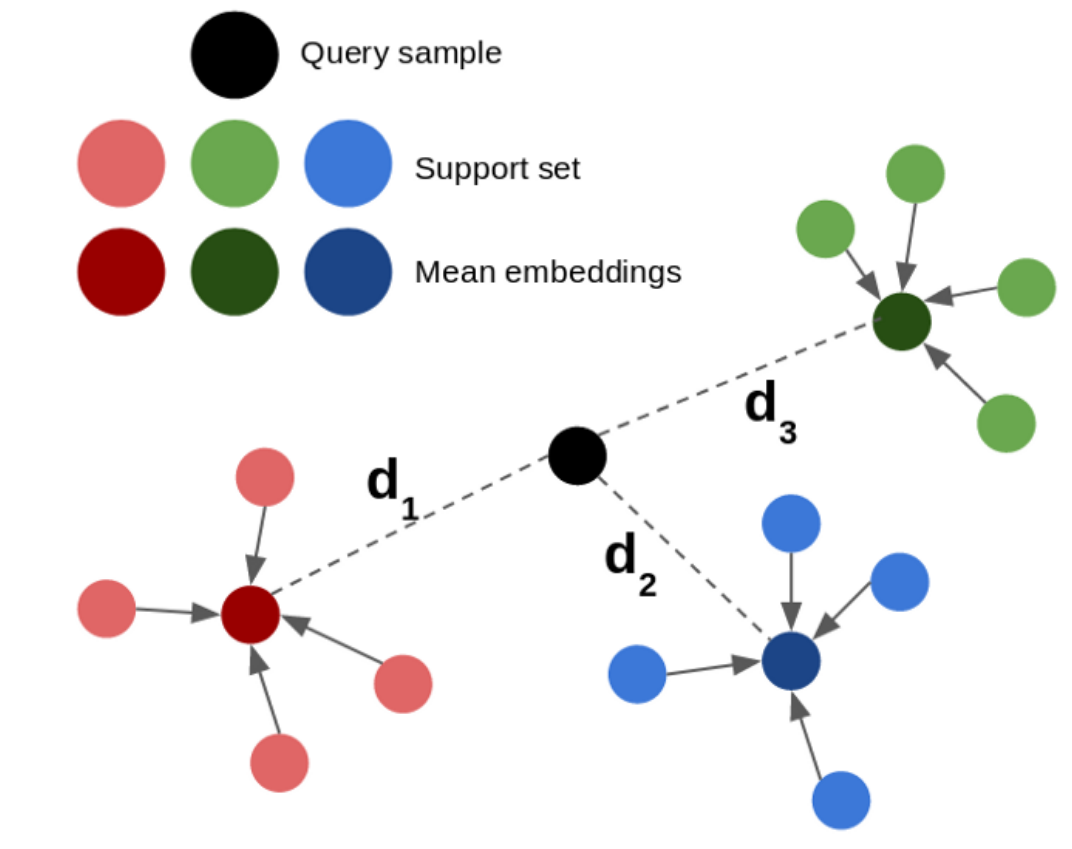

## Model Definition



Here I use the pytorch to build model

## DataLoad

In [ ]:

from torch.utils.data import Dataset
# for pytorch implement
class SpeakerDataset(Dataset):   
    def __init__(self):
        training = !!bool "true"
#------

        if training:
            self.path = train_path_unprocessed
            self.utterance_number =M
        else:
            self.path = test_path_unprocessed
            self.utterance_number = test_M
        self.speakers = glob.glob(os.path.dirname(self.path))
        shuffle(self.speakers)
        
    def __len__(self):
        return len(self.speakers)

    def __getitem__(self, idx):
        
        speaker = self.speakers[idx]
        wav_files = glob.glob(speaker+'/*.WAV')
        shuffle(wav_files)
        wav_files = wav_files[0:self.utterance_number]
        
        mel_dbs = []
        for f in wav_files:
            _, mel_db, _ = mfccs_and_spec(f, wav_process = True)
            mel_dbs.append(mel_db)
        return torch.Tensor(mel_dbs)

class SpeakerDatasetPreprocessed(Dataset):
    
    def __init__(self, shuffle=True, utter_start=0):
        
        # data path
        if training:
            self.path = train_path
            self.utter_num = M #train_M
        else:
            self.path = test_path
            self.utter_num = test_M
        self.file_list = os.listdir(self.path)
        self.shuffle=shuffle
        self.utter_start = utter_start
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        
        np_file_list = os.listdir(self.path)
        
        if self.shuffle:
            selected_file = random.sample(np_file_list, 1)[0]  # select random speaker
        else:
            selected_file = np_file_list[idx]               
        
        utters = np.load(os.path.join(self.path, selected_file))        # load utterance spectrogram of selected speaker
        if self.shuffle:
            utter_index = np.random.randint(0, utters.shape[0], self.utter_num)   # select M utterances per speaker
            utterance = utters[utter_index]       
        else:
            utterance = utters[self.utter_start: self.utter_start+self.utter_num] # utterances of a speaker [batch(M), n_mels, frames]

        utterance = utterance[:,:,:160]               # TODO implement variable length batch size

        utterance = torch.tensor(np.transpose(utterance, axes=(0,2,1)))     # transpose [batch, frames, n_mels]
        return utterance



In [ ]:
libri_train
libri_val
libri_test

In [ ]:
def prepare_data(self):
  ##prepare transform to dataset
  

## training

In [ ]:
#set to be trained mode
training = !!bool "true"


In [ ]:
train_path= './train_tisv'
train_path_unprocessed= '/content/drive/MyDrive/TIMIT/TRAIN/*/*/*.wav'

unprocessed_data= '/content/drive/MyDrive/TIMIT/*/*/*/*.wav'


In [ ]:
#some extra function for the model 
import torch.autograd as grad

def get_centroids_prior(embeddings):
    centroids = []
    for speaker in embeddings:
        centroid = 0
        for utterance in speaker:
            centroid = centroid + utterance
        centroid = centroid/len(speaker)
        centroids.append(centroid)
    centroids = torch.stack(centroids)
    return centroids

def get_centroids(embeddings):
    centroids = embeddings.mean(dim=1)
    return centroids

def get_centroid(embeddings, speaker_num, utterance_num):
    centroid = 0
    for utterance_id, utterance in enumerate(embeddings[speaker_num]):
        if utterance_id == utterance_num:
            continue
        centroid = centroid + utterance
    centroid = centroid/(len(embeddings[speaker_num])-1)
    return centroid

def get_utterance_centroids(embeddings):
    """
    Returns the centroids for each utterance of a speaker, where
    the utterance centroid is the speaker centroid without considering
    this utterance

    Shape of embeddings should be:
        (speaker_ct, utterance_per_speaker_ct, embedding_size)
    """
    sum_centroids = embeddings.sum(dim=1)
    # we want to subtract out each utterance, prior to calculating the
    # the utterance centroid
    sum_centroids = sum_centroids.reshape(
        sum_centroids.shape[0], 1, sum_centroids.shape[-1]
    )
    # we want the mean but not including the utterance itself, so -1
    num_utterances = embeddings.shape[1] - 1
    centroids = (sum_centroids - embeddings) / num_utterances
    return centroids

def get_cossim_prior(embeddings, centroids):
    # Calculates cosine similarity matrix. Requires (N, M, feature) input
    cossim = torch.zeros(embeddings.size(0),embeddings.size(1),centroids.size(0))
    for speaker_num, speaker in enumerate(embeddings):
        for utterance_num, utterance in enumerate(speaker):
            for centroid_num, centroid in enumerate(centroids):
                if speaker_num == centroid_num:
                    centroid = get_centroid(embeddings, speaker_num, utterance_num)
                output = F.cosine_similarity(utterance,centroid,dim=0)+1e-6
                cossim[speaker_num][utterance_num][centroid_num] = output
    return cossim

def get_cossim(embeddings, centroids):
    # number of utterances per speaker
    num_utterances = embeddings.shape[1]
    utterance_centroids = get_utterance_centroids(embeddings)

    # flatten the embeddings and utterance centroids to just utterance,
    # so we can do cosine similarity
    utterance_centroids_flat = utterance_centroids.view(
        utterance_centroids.shape[0] * utterance_centroids.shape[1],
        -1
    )
    embeddings_flat = embeddings.view(
        embeddings.shape[0] * num_utterances,
        -1
    )
    # the cosine distance between utterance and the associated centroids
    # for that utterance
    # this is each speaker's utterances against his own centroid, but each
    # comparison centroid has the current utterance removed
    cos_same = F.cosine_similarity(embeddings_flat, utterance_centroids_flat)

    # now we get the cosine distance between each utterance and the other speakers'
    # centroids
    # to do so requires comparing each utterance to each centroid. To keep the
    # operation fast, we vectorize by using matrices L (embeddings) and
    # R (centroids) where L has each utterance repeated sequentially for all
    # comparisons and R has the entire centroids frame repeated for each utterance
    centroids_expand = centroids.repeat((num_utterances * embeddings.shape[0], 1))
    embeddings_expand = embeddings_flat.unsqueeze(1).repeat(1, embeddings.shape[0], 1)
    embeddings_expand = embeddings_expand.view(
        embeddings_expand.shape[0] * embeddings_expand.shape[1],
        embeddings_expand.shape[-1]
    )
    cos_diff = F.cosine_similarity(embeddings_expand, centroids_expand)
    cos_diff = cos_diff.view(
        embeddings.size(0),
        num_utterances,
        centroids.size(0)
    )
    # assign the cosine distance for same speakers to the proper idx
    same_idx = list(range(embeddings.size(0)))
    cos_diff[same_idx, :, same_idx] = cos_same.view(embeddings.shape[0], num_utterances)
    cos_diff = cos_diff + 1e-6
    return cos_diff

def calc_loss_prior(sim_matrix):
    # Calculates loss from (N, M, K) similarity matrix
    per_embedding_loss = torch.zeros(sim_matrix.size(0), sim_matrix.size(1))
    for j in range(len(sim_matrix)):
        for i in range(sim_matrix.size(1)):
            per_embedding_loss[j][i] = -(sim_matrix[j][i][j] - ((torch.exp(sim_matrix[j][i]).sum()+1e-6).log_()))
    loss = per_embedding_loss.sum()    
    return loss, per_embedding_loss

def calc_loss(sim_matrix):
    same_idx = list(range(sim_matrix.size(0)))
    pos = sim_matrix[same_idx, :, same_idx]
    neg = (torch.exp(sim_matrix).sum(dim=2) + 1e-6).log_()
    per_embedding_loss = -1 * (pos - neg)
    loss = per_embedding_loss.sum()
    return loss, per_embedding_loss

def normalize_0_1(values, max_value, min_value):
    normalized = np.clip((values - min_value) / (max_value - min_value), 0, 1)
    return normalized

def mfccs_and_spec(wav_file, wav_process = False, calc_mfccs=False, calc_mag_db=False):    
    sound_file, _ = librosa.core.load(wav_file, sr=sr)
    window_length = int(window*sr)
    hop_length = int(hop*sr)
    duration = tisv_frame * hop + window
    
    # Cut silence and fix length
    if wav_process == True:
        sound_file, index = librosa.effects.trim(sound_file, frame_length=window_length, hop_length=hop_length)
        length = int(sr * duration)
        sound_file = librosa.util.fix_length(sound_file, length)
        
    spec = librosa.stft(sound_file, n_fft=nfft, hop_length=hop_length, win_length=window_length)
    mag_spec = np.abs(spec)
    
    mel_basis = librosa.filters.mel(sr, nfft, n_mels=nmels)
    mel_spec = np.dot(mel_basis, mag_spec)
    
    mag_db = librosa.amplitude_to_db(mag_spec)
    #db mel spectrogram
    mel_db = librosa.amplitude_to_db(mel_spec).T
    
    mfccs = None
    if calc_mfccs:
        mfccs = np.dot(librosa.filters.dct(40, mel_db.shape[0]), mel_db).T
    
    return mfccs, mel_db, mag_db

if __name__ == "__main__":
    w = grad.Variable(torch.tensor(1.0))
    b = grad.Variable(torch.tensor(0.0))
    embeddings = torch.tensor([[0,1,0],[0,0,1], [0,1,0], [0,1,0], [1,0,0], [1,0,0]]).to(torch.float).reshape(3,2,3)
    centroids = get_centroids(embeddings)
    cossim = get_cossim(embeddings, centroids)
    sim_matrix = w*cossim + b
    loss, per_embedding_loss = calc_loss(sim_matrix)

This is for speech embedding

In [ ]:
#speach embedder pytorch
class SpeechEmbedder(nn.Module):
    
    def __init__(self):
      # super avoid call the 
        nmels =40 #Number of mel energies
        hidden= 768 #Number of LSTM hidden layer units
        proj=256 #Embedding size
        num_layer=3
        super(SpeechEmbedder, self).__init__()    
        self.LSTM_stack = nn.LSTM(nmels, hidden, num_layers=num_layer, batch_first=True)
        for name, param in self.LSTM_stack.named_parameters():
          if 'bias' in name:
             nn.init.constant_(param, 0.0)
          elif 'weight' in name:
            #Fills the input Tensor with values according to the method 
             nn.init.xavier_normal_(param)
        self.projection = nn.Linear(hidden, proj)
        
    def forward(self, x):
        x, _ = self.LSTM_stack(x.float()) #(batch, frames, n_mels)
        #only use last frame
        x = x[:,x.size(1)-1]
        x = self.projection(x.float())
        x = x / torch.norm(x, dim=1).unsqueeze(1)
        return x

## using Generalized end to end loss function. 
class GE2ELoss(nn.Module):
    
    def __init__(self, device):
        super(GE2ELoss, self).__init__()
        self.w = nn.Parameter(torch.tensor(10.0).to(device), requires_grad=True)
        self.b = nn.Parameter(torch.tensor(-5.0).to(device), requires_grad=True)
        self.device = device
    
    def forward(self, embeddings):
        torch.clamp(self.w, 1e-6)
        centroids = get_centroids(embeddings)
        cossim = get_cossim(embeddings, centroids)
        sim_matrix = self.w*cossim.to(self.device) + self.b
        loss, _ = calc_loss(sim_matrix)
        return loss


In [ ]:
#parameter for trainning

N=4 #Number of speakers in batch
M=5 #Number of utterances per speaker

num_workers= 2 #number of workers for dataloader
lr=0.01 
epochs= 950 #Max training speaker epoch 
log_file='./speech_id_checkpoint/Stats' #save on google drive
#log_file='/content/drive/MyDrive/Pytorchmodel/speech_id_checkpoint/Stats' #save on google drive

log_interval= 30 #Epochs before printing progress
checkpoint_interval= 120 #Save model after x speaker epochs
checkpoint_dir= './speech_id_checkpoint'
#checkpoint_dir= '/content/drive/MyDrive/Pytorchmodel/speech_id_checkpoint'
restore= !!bool "true" #Resume training from previous model path

#point for starting 
data_preprocessed= !!bool "true"

then

In [ ]:
#parameter for test

test_M= 6
test_N= 4 #Number of utterances per speaker


test_path_unprocessed='/content/drive/MyDrive/TIMIT/TEST/*/*/*.wav'
test_path ='./test_tisv'
test_epochs =10

In [ ]:
from torch.utils.data import DataLoader
#trainning the
def train(model_path):
    data_preprocessed= !!bool "false"#determine
    device = torch.device("cuda") #use cuda
    if data_preprocessed: #data preprecessed
        train_dataset = SpeakerDatasetPreprocessed()
    else:
        train_dataset = SpeakerDataset()
    train_loader = DataLoader(train_dataset, batch_size=N, shuffle=True, num_workers=num_workers, drop_last=True) 
    
    embedder_net = SpeechEmbedder().to(device)
    if restore:
        embedder_net.load_state_dict(torch.load(model_path))
    ge2e_loss = GE2ELoss(device)
    #Both net and loss have trainable parameters
    optimizer = torch.optim.SGD([
                    {'params': embedder_net.parameters()},
                    {'params': ge2e_loss.parameters()}
                ], lr=lr)
    
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    embedder_net.train()
    iteration = 0
    for e in range(epochs):
        total_loss = 0
        for batch_id, mel_db_batch in enumerate(train_loader): 
            mel_db_batch = mel_db_batch.to(device)
            
            mel_db_batch = torch.reshape(mel_db_batch, (N*M, mel_db_batch.size(2), mel_db_batch.size(3)))
            perm = random.sample(range(0, N*M), N*M)
            unperm = list(perm)
            for i,j in enumerate(perm):
                unperm[j] = i
            mel_db_batch = mel_db_batch[perm]
            #gradient accumulates
            optimizer.zero_grad()
            
            embeddings = embedder_net(mel_db_batch)
            embeddings = embeddings[unperm]
            embeddings = torch.reshape(embeddings, (N, M, embeddings.size(1)))
            
            #get loss, call backward, step optimizer
            loss = ge2e_loss(embeddings) #wants (Speaker, Utterances, embedding)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(embedder_net.parameters(), 3.0)
            torch.nn.utils.clip_grad_norm_(ge2e_loss.parameters(), 1.0)
            optimizer.step()
            
            total_loss = total_loss + loss
            iteration += 1
            if (batch_id + 1) % log_interval == 0:
                mesg = "{0}\tEpoch:{1}[{2}/{3}],Iteration:{4}\tLoss:{5:.4f}\tTLoss:{6:.4f}\t\n".format(time.ctime(), e+1,
                        batch_id+1, len(train_dataset)//N, iteration,loss, total_loss / (batch_id + 1))
                print(mesg)
                if log_file is not None:
                    with open(log_file,'a') as f:
                        f.write(mesg)
                    
        if checkpoint_dir is not None and (e + 1) % checkpoint_interval == 0:
            embedder_net.eval().cpu()
            ckpt_model_filename = "ckpt_epoch_" + str(e+1) + "_batch_id_" + str(batch_id+1) + ".pth"
            ckpt_model_path = os.path.join(checkpoint_dir, ckpt_model_filename)
            torch.save(embedder_net.state_dict(), ckpt_model_path)
            embedder_net.to(device).train()

    #save model
    embedder_net.eval().cpu()
    save_model_filename = "final_epoch_" + str(e + 1) + "_batch_id_" + str(batch_id + 1) + ".model"
    save_model_path = os.path.join(checkpoint_dir, save_model_filename)
    torch.save(embedder_net.state_dict(), save_model_path)
    print("\nDone, trained model saved at", save_model_path)




In [ ]:
import random
import time

The model is uploaded on the github, which has this name of final_epoch_batchid141.

In [ ]:
#save on google drive
model_path= '/content/drive/MyDrive/Pytorchmodel/model.model'

In [ ]:
def test(model_path):
    #save on google drive
    if data_preprocessed:
        test_dataset = SpeakerDatasetPreprocessed()
    else:
        test_dataset = SpeakerDataset()
    test_loader = DataLoader(test_dataset, batch_size=test_N, shuffle=True, num_workers=test_num_workers, drop_last=True)
    embedder_net = SpeechEmbedder()
    embedder_net.load_state_dict(torch.load(model_path))
    embedder_net.eval()
    
    avg_EER = 0
    for e in range(test_epochs):
        batch_avg_EER = 0
        model_path= '/content/drive/MyDrive/Pytorchmodel/model.model'

        for batch_id, mel_db_batch in enumerate(test_loader):
            assert test_M % 2 == 0
            enrollment_batch, verification_batch = torch.split(mel_db_batch, int(mel_db_batch.size(1)/2), dim=1)
            
            enrollment_batch = torch.reshape(enrollment_batch, (test_N*test_M//2, enrollment_batch.size(2), enrollment_batch.size(3)))
            verification_batch = torch.reshape(verification_batch, (test_N*test_M//2, verification_batch.size(2), verification_batch.size(3)))
            
            perm = random.sample(range(0,verification_batch.size(0)), verification_batch.size(0))
            unperm = list(perm)
            for i,j in enumerate(perm):
                unperm[j] = i
                
            verification_batch = verification_batch[perm]
            enrollment_embeddings = embedder_net(enrollment_batch)
            verification_embeddings = embedder_net(verification_batch)
            verification_embeddings = verification_embeddings[unperm]
            
            enrollment_embeddings = torch.reshape(enrollment_embeddings, (test_N, test_M//2, enrollment_embeddings.size(1)))
            verification_embeddings = torch.reshape(verification_embeddings, (test_N, test_M//2, verification_embeddings.size(1)))
            
            enrollment_centroids = get_centroids(enrollment_embeddings)
            
            sim_matrix = get_cossim(verification_embeddings, enrollment_centroids)
            
            # calculating EER
            diff = 1; EER=0; EER_thresh = 0; EER_FAR=0; EER_FRR=0
            
            for thres in [0.01*i+0.5 for i in range(50)]:
                sim_matrix_thresh = sim_matrix>thres
                
                FAR = (sum([sim_matrix_thresh[i].float().sum()-sim_matrix_thresh[i,:,i].float().sum() for i in range(int(test_N))])
                /(test_N-1.0)/(float(test_M/2))/test_N)
    
                FRR = (sum([test_M/2-sim_matrix_thresh[i,:,i].float().sum() for i in range(int(test_N))])
                /(float(test_M/2))/test_N)
                
                # Save threshold when FAR = FRR (=EER)
                if diff> abs(FAR-FRR):
                    diff = abs(FAR-FRR)
                    EER = (FAR+FRR)/2
                    EER_thresh = thres
                    EER_FAR = FAR
                    EER_FRR = FRR
            batch_avg_EER += EER
            print("\nEER : %0.2f (thres:%0.2f, FAR:%0.2f, FRR:%0.2f)"%(EER,EER_thresh,EER_FAR,EER_FRR))
        avg_EER += batch_avg_EER/(batch_id+1)
    avg_EER = avg_EER / test_epochs
    print("\n EER across {0} epochs: {1:.4f}".format(test_epochs, avg_EER))
        
if __name__=="__main__":
    if training:
        train(model_path)
    else:
        test(model_path)

Tue Dec 15 16:05:45 2020	Epoch:1[30/141],Iteration:30	Loss:0.1378	TLoss:0.7568	

Tue Dec 15 16:05:49 2020	Epoch:1[60/141],Iteration:60	Loss:0.7330	TLoss:0.8177	

Tue Dec 15 16:05:52 2020	Epoch:1[90/141],Iteration:90	Loss:0.7213	TLoss:0.8929	

Tue Dec 15 16:05:56 2020	Epoch:1[120/141],Iteration:120	Loss:0.4314	TLoss:0.8777	

Tue Dec 15 16:06:03 2020	Epoch:2[30/141],Iteration:171	Loss:2.5063	TLoss:1.2737	

Tue Dec 15 16:06:06 2020	Epoch:2[60/141],Iteration:201	Loss:2.0889	TLoss:1.3387	

Tue Dec 15 16:06:10 2020	Epoch:2[90/141],Iteration:231	Loss:0.5629	TLoss:1.1861	

Tue Dec 15 16:06:14 2020	Epoch:2[120/141],Iteration:261	Loss:0.2537	TLoss:1.1095	

Tue Dec 15 16:06:21 2020	Epoch:3[30/141],Iteration:312	Loss:0.2035	TLoss:0.3802	

Tue Dec 15 16:06:25 2020	Epoch:3[60/141],Iteration:342	Loss:1.3200	TLoss:0.6082	

Tue Dec 15 16:06:28 2020	Epoch:3[90/141],Iteration:372	Loss:0.0192	TLoss:0.6876	

Tue Dec 15 16:06:32 2020	Epoch:3[120/141],Iteration:402	Loss:0.2893	TLoss:0.7575	

Tue Dec 15 16:06

As the time stamp showed, on this baseline version of code, It takes about 2 hrs to train 400 epoch of preprocessed TIMIT dataset on a gpu of colab. on the contrast, I used a gpu of gtx1050ti totally spend 20hours of trainning on 950 epochs. The detailed stats are shown on the github 21hr_training_Stats_local_machine.



This baseline performance can reach 3.77% EER which means it has about 96.3% of correctness to predict whether person is from the registered or not

Due to this huge requirement on computation, I then reduce the parameters for the network. The preposition holds that although the performance is degraded overall, the structure of the network still keeps the same. In this scenario, if I add some structure to improve the performance of the whiole network, it is very likely that the property holds and in a complete network, the added structure can increase the performance. 

**The parameter of baseline can be showed on this list：**

sr: 16000
    nfft: 512 #For mel spectrogram preprocess
    window: 0.025 #(s)
    hop: 0.01 #(s)
    nmels: 40 #Number of mel energies

--- 

model:
    hidden: 768 #Number of LSTM hidden layer units
    num_layer: 3 #Number of LSTM layers
    proj: 256 #Embedding size

---
train:

    num_workers: 2 #number of workers for dataloader
    lr: 0.01 
    epochs: 950 #Max training speaker epoch 
    log_interval: 30 


**Revised result parameter for the baseline as showed here**

sr: 8000 # cut sample rate to half on preprocess
    nfft: 256 #For mel spectrogram preprocess
    nmels: 20 #Number of mel energies

--- 

model:
    hidden: 192 #Number of LSTM hidden layer units
    num_layer: 2 #Number of LSTM layers
    proj: 64 #Embedding size



I reduced almost at least two times for the most parameter and I expect to get a much lower result. Interesting I still get 0.2018 EER, which means the system can still holds about 80% chance to correctly predict the person. 

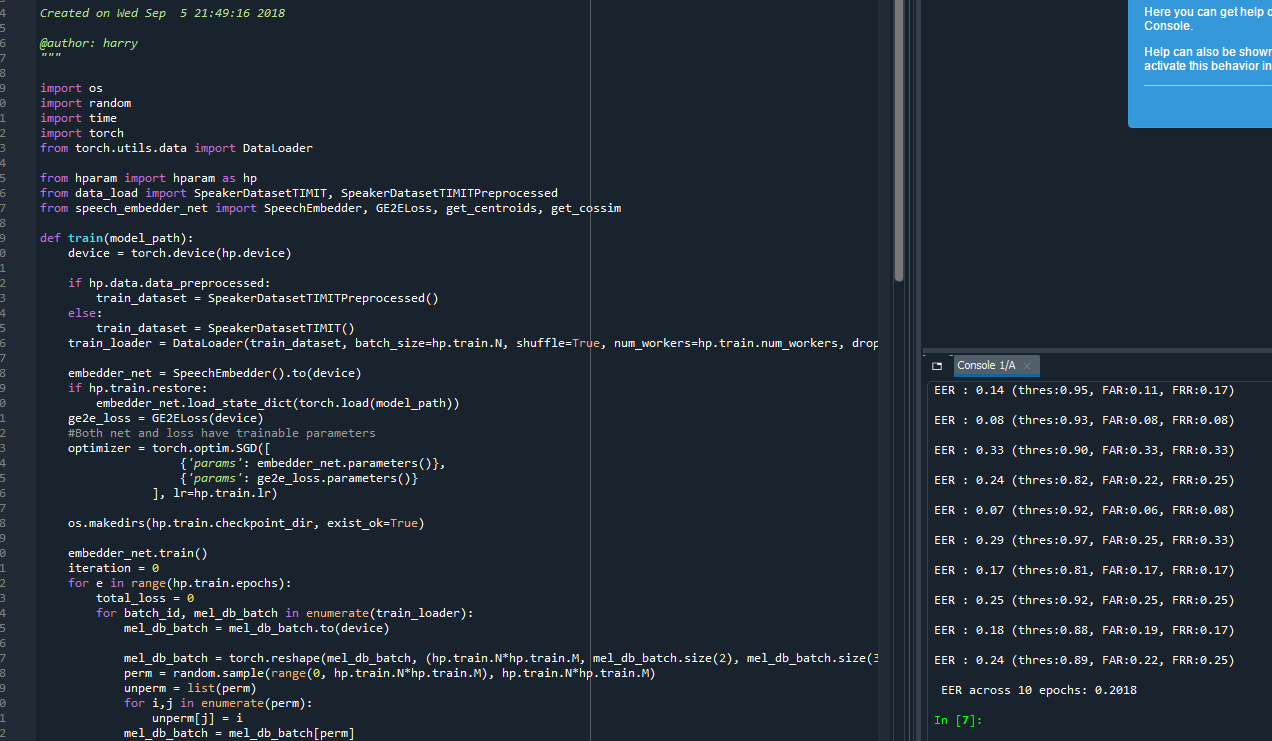

The downgraded baseline also showed a interesting facts, the originial hidden layers or other hyperparameters are quite redundent and huge increase of parameters does not increase largely on the performance. 

I then added a relatively small CNN structure of the network and did not increase a huge number of parameters of it. 

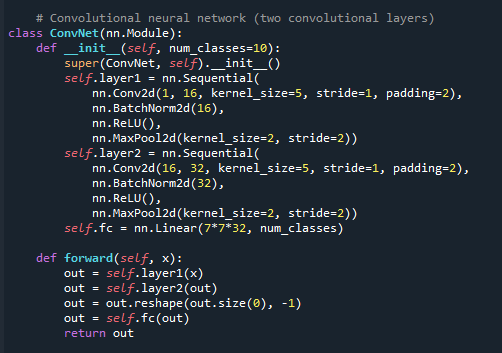

# Performance Check

I just added a two layer structure of the CNN into existing network and I tested with the result. the perfomance of the mixed structure is not huge, and it seemed to be about 10% or within through the run. But This may implied that in a larger scale of the parameter, CNN structure can increse the performance of the whole system

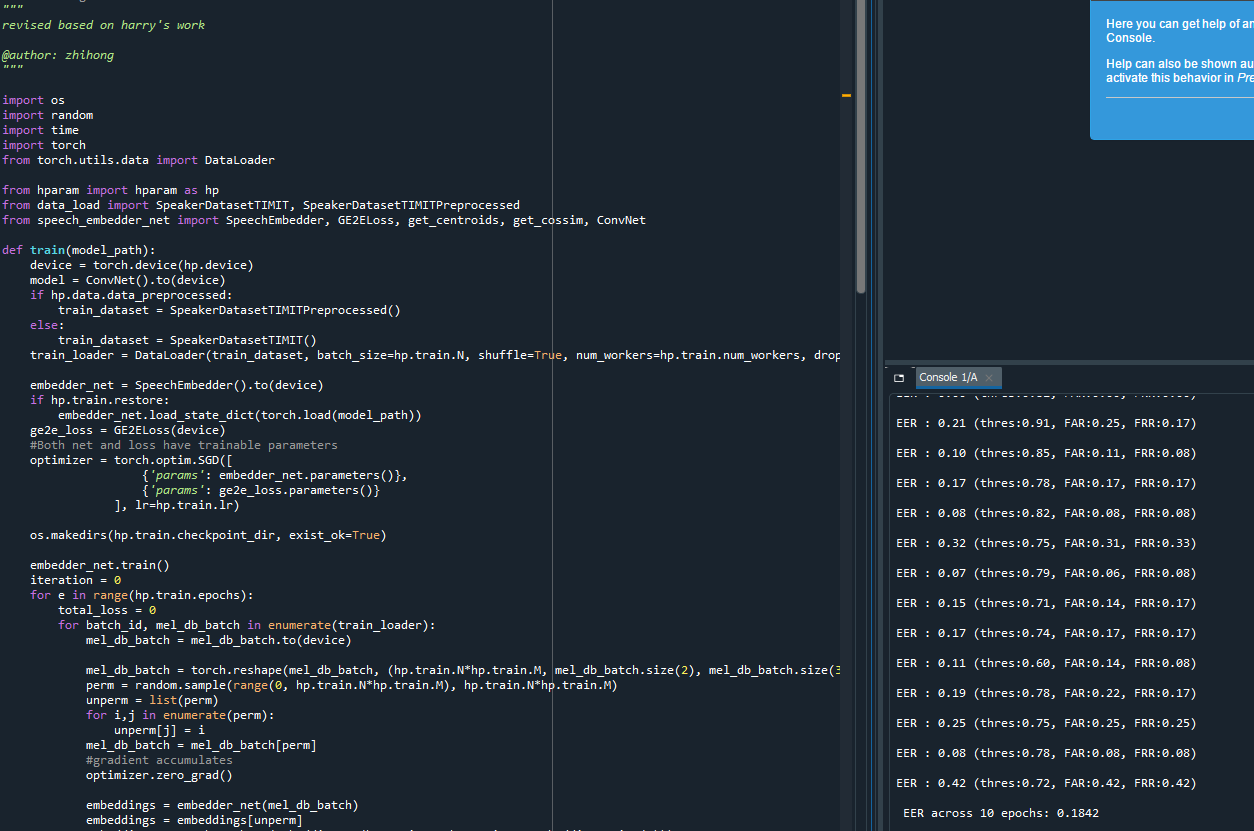

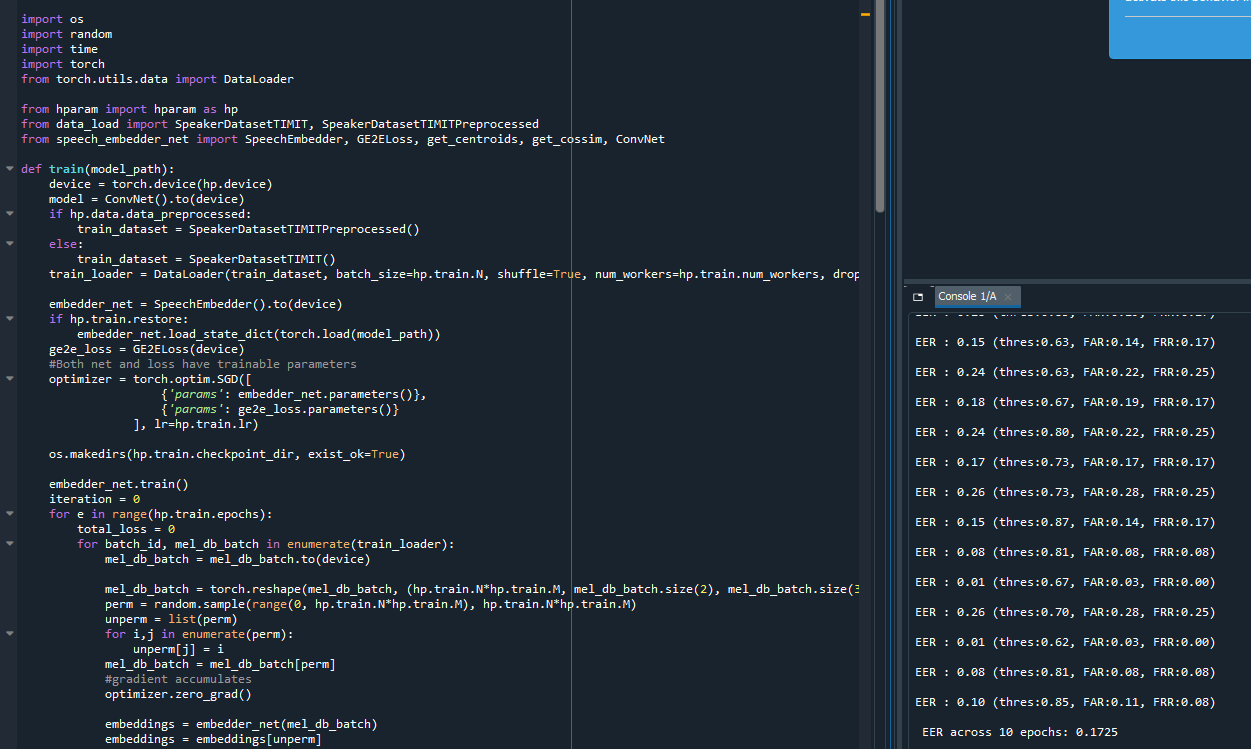

I think it is still valuable to add CNN structure of the system and it potentially increase the performance on a larger dataset. 

# Final Result:



Here I got the result of EER of around 18% of EER, it increase about 10% or less of the performance since the network is not well-designed. It may perform better if we design CNN in a better way. However, statastically it may also be about the same level of performance due to this insignificant increase on the performance. However, the project still interest me a bit on the rethinking of what actual means to design neural and layers.  

# Future improvement based on this project
Due to the time constraint, I was unable to finsih this transfer learning process to other language within the time frame. 

During this process, Another phenomenon attracted my attention is this redundancy of the layer size of the neural network. 
The dramatic cut of the parameters does not decrease the project as it should be, it will raise the questions about make the network more efficient instead of making bigger and spend more time on the trainning. On this point of view, OI also explored some early work since 90s. Like some method of reduce hidden layer size (https://ieeexplore.ieee.org/document/624936 ), I think use hidden layers efficiently will be beneficial when the model inevitablly goes larger. 

In this perspective, both transfer learning and CNN are training to reuse some of the parameters to provide better efficiency. 
In contrast to always enlarging the model perameters, move direction to a smaller but efficient model may be another direction to go for the deep-learning. 

# Reference

Paper ( the list is quite long, therefor I just picked some most influencing on finishing this project
1. core paper Generalized End to End Loss for speaker verification arXiv:1710.10467v4  

2. CNN WITH PHONETIC ATTENTION FOR TEXT-INDEPENDENT SPEAKER VERIFICATION

3. Speaker recognition by machines and humans: A tutorial review 
 *Hansen, John H.L. Hasan, Taufiq*

4. 








Noise recognition of power transformers based on improved MFCC and VQ 



code list:


https://github.com/HarryVolek/PyTorch_Speaker_Verification  

https://github.com/Janghyun1230/Speaker_Verification 

https://github.com/mystlee/rasta_py/blob/master/rasta.py 
